- I created a new conda environment to install keras
- Then I created a second keras environment to install Keras 2.3.1 due to bugs.

In [1]:
import numpy as np

npzfile = np.load('/home/dyllanjr/Solar_Irradiance_Prediction/data/processed/Arkansas_look_back_48.npz')

In [2]:
np.__version__

'1.20.0'

In [3]:
Xs = npzfile['x']
y = npzfile['y']

In [4]:
import keras
import numpy as np

Using TensorFlow backend.


In [5]:
### I need to split my Xs into categorical and numericals
#I'm going to just use the numerical columns first.
cat_data = Xs[:,:,[0,2]]
num_data = Xs[:,:,[1,3,4,5,6,7]]

['Cloud Type',
 'Dew Point',
 'Fill Flag',
 'Wind Speed',
 'Surface Albedo',
 'Temperature',
 'Solar Zenith Angle',
 'Wind Direction']

In [6]:
test = np.random.randint(0,4,10)
test.shape

(10,)

In [7]:
from keras.layers import Embedding, Reshape, Dense, Concatenate, Lambda
from keras.layers.recurrent import LSTM, RNN
from keras.models import Sequential, Input
from keras import backend
import pandas as pd

In [8]:
num_data[0].shape

(48, 6)

In [9]:
# One embedding for each categorical feature (cloud type and fill flag)

#cloud type c1, fill_flag c2
c1 = cat_data[:, :, 0]
c2 = cat_data[:, :, 1]

#Embedding for cloud type
num_unique1 = pd.DataFrame(c1).nunique().max()
embedding_size1 = min(np.ceil((num_unique1)/2), 50)
embedding_size1 = int(embedding_size1)
vocab1 = num_unique1+1
embed1_in = Input(shape=(48,), name='cloud_type')
embedding1 = Embedding(vocab1, embedding_size1, input_length = 48)
x1 = embedding1(embed1_in)

#Embedding for fill flag
num_unique2 = pd.DataFrame(c2).nunique().max()
embedding_size2 = min(np.ceil((num_unique2)/2), 50)
embedding_size2 = int(embedding_size2)
vocab2 = num_unique2+1
embed2_in = Input(shape=(48,), name='fill_flag')
embedding2 = Embedding(vocab2, embedding_size2, input_length = 48)
x2 = embedding2(embed2_in)

#Input for numerical data
numerical_in = Input(shape=(48, 6), name='numerical')

#concat inputs of embedding layerse and numerical data
cat_nums = Concatenate(axis=2)([x1, x2, numerical_in])

#Three large lstm layers
l1 = LSTM(300, return_sequences=True)(cat_nums)
l2 = LSTM(300, return_sequences=True)(l1)
l3 = LSTM(300)(l2)

#final output layers
d1 = Dense(10, activation = 'relu')(l3)
output = Dense(1, activation='sigmoid')(d1)

## sum half-hourly GHI predictions for daily total GHI prediction
# def summer(x):
#     return backend.sum(x, axis=1)

# summed_output = Lambda(summer)(output)
#Instantiate model
model = keras.Model(
    inputs=[embed1_in, embed2_in, numerical_in],
    outputs=[output])

/home/dyllanjr/Solar_Irradiance_Prediction/reports/figures


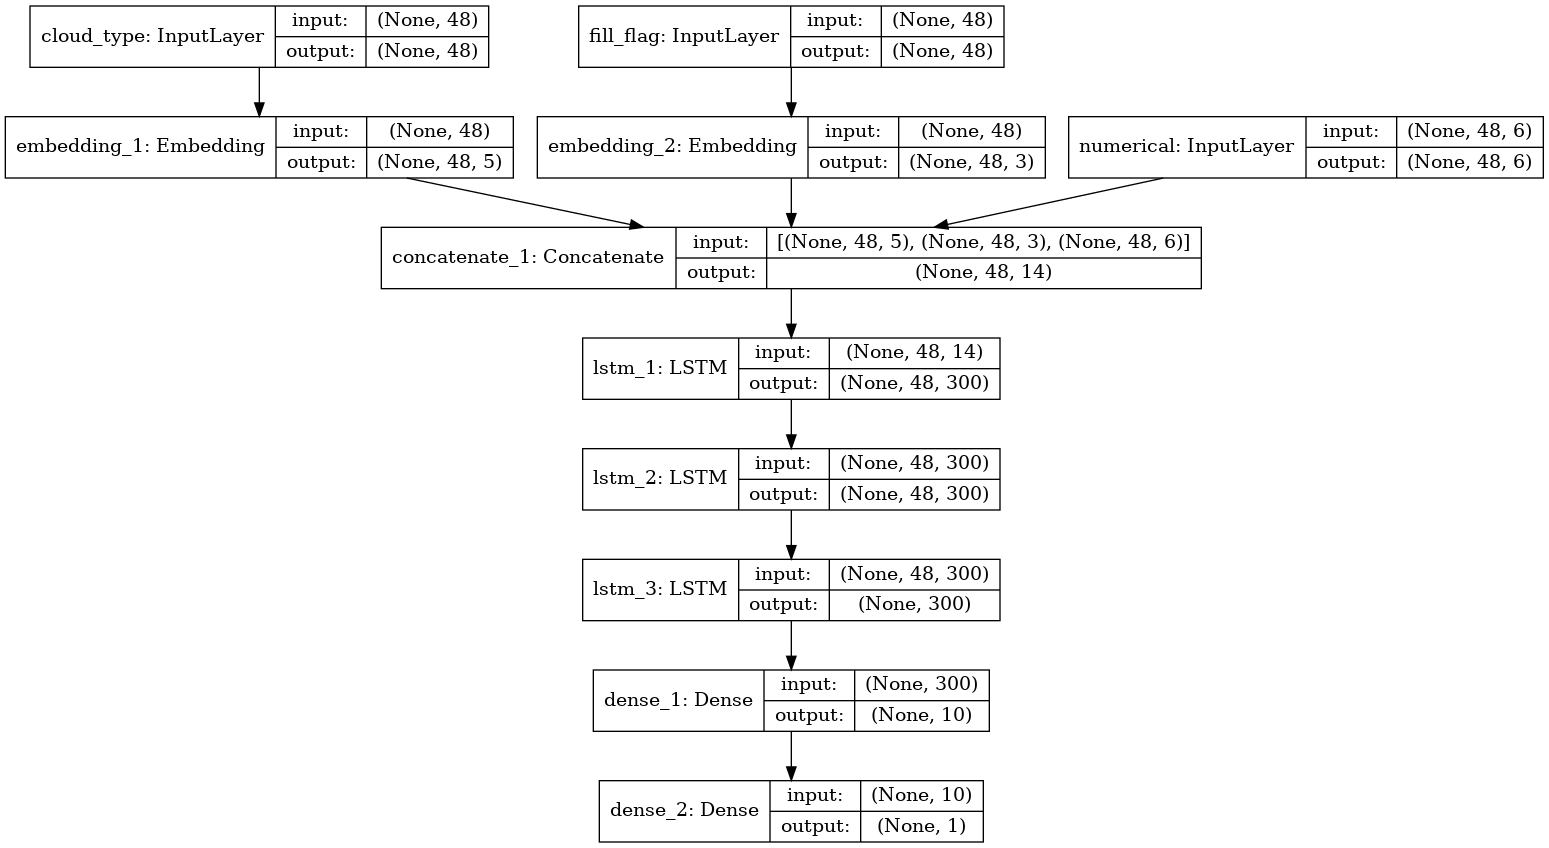

In [10]:
%cd /home/dyllanjr/Solar_Irradiance_Prediction/reports/figures
from keras.utils import plot_model

plot_model(model, 'lstm_with_embedding.png', show_shapes = True)

In [11]:
l3.shape

TensorShape([None, 300])

In [12]:
d1.shape

TensorShape([None, 10])

In [13]:
output.shape

TensorShape([None, 1])

In [14]:
import tensorflow as tf

In [15]:
#Set optimizer and loss function
model.compile(
    loss='mse',
    optimizer=tf.optimizers.Adam()
)

In [16]:
#Train-test splitting numerical and categorical data features

cat_train, cat_test= np.split(cat_data, [int(.85 *len(cat_data))])
cloud_train, cloud_test = cat_train[:, :, 0], cat_test[:, :, 0]
fill_flag_train, fill_flag_test = cat_train[:, :, 1], cat_test[:, :, 1]
num_train, num_test = np.split(num_data, [int(.85 *len(num_data))])

#Train-test splitting target 
#sum each batch (one day of values, 48 half hours)
y_sum = np.sum(y, axis=1)
y_train, y_test = np.split(y_sum, [int(.85 *len(y_sum))])

In [19]:
model.fit(
    x={'cloud_type': cloud_train, 'fill_flag': fill_flag_train, 'numerical': num_train},
    y=y_train,
    epochs=2,
    batch_size=32)

Epoch 1/2
1216/6204 [====>.........................] - ETA: 4:16 - loss: 104936702.1053

KeyboardInterrupt: 

In [ ]:
test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

In [ ]:
y_test.shape